In [7]:
from dotenv import load_dotenv

load_dotenv()

True

In [8]:
from langchain_ollama import ChatOllama


base_url = "http://localhost:11434"
model = 'llama3.2'

llm = ChatOllama(base_url=base_url, model=model)
llm

ChatOllama(model='llama3.2', base_url='http://localhost:11434')

In [ ]:
llm.invoke("What is the capital of France?")

In [12]:
from langchain_community.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain.chains import RetrievalQA
from langchain.llms import OpenAI
from langchain.prompts import PromptTemplate
from langchain.memory import ConversationBufferMemory
from langchain.chains import LLMChain
from tqdm import tqdm
from langchain.document_loaders import TextLoader
from langchain.document_loaders import DirectoryLoader

In [10]:
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate

class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the topic, 'yes' or 'no'"
    )


structured_llm_grader = llm.with_structured_output(GradeDocuments)

system = """You are a grader assessing relevance of a retrieved document to a apply graduate. \n 
    Determine if this text is relevant to university applications based on these specific criteria:
    1. Content about professors (contact information, research interests, biographies, etc.)
    2. Information about graduate applications and programs (requirements, TOEFL/GRE scores, application processes)
    3. Details about research topics, including funding information
    4. Any other information that can be helpful for applying graduate
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to this topic."""
# system = """You are a grader assessing relevance of a retrieved document to a apply graduate. \n 
#     Any information that can be helpful for applying graduate students such as graduate programs, requirments for apply, departmenst information, \n
#     professors information, and any other information that can be helpful for applying graduate students should be mark as relevent. \n
#     Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to this topic."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader


In [17]:
from typing import List, TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        documents: list of documents
    """

    # question: str
    # generation: str
    # web_search: bool
    documents: List[str]


In [ ]:
from typing import Any, Dict


def retrieve(state: GraphState) -> Dict[str, Any]:
    print("---RETRIEVE---")
    loader = DirectoryLoader(
        "../data/crawled_content/",
        glob="**/utsa_*_*.txt",
        loader_cls=TextLoader,
        loader_kwargs={
            "encoding": "utf8",  # Specify encoding
            "autodetect_encoding": True,  # Automatically detect encoding
        },
        show_progress=True,  # Show loading progress
        silent_errors=False,  # Handle errors without stopping
    )

    documents = loader.load()
    text_splitter = RecursiveCharacterTextSplitter(
    separators=["LINK:"]
    )
    chunks = text_splitter.split_documents(documents)
    
    return {"documents": chunks}

In [23]:
def grade_documents(state: GraphState) -> Dict[str, Any]:
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    documents = state["documents"]

    filtered_docs = []
    for d in tqdm(documents):
        score = retrieval_grader.invoke(
            {"document": d.page_content}
        )
        grade = score.binary_score
        if grade.lower() == "yes":
            # print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            # print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    print(f"Number of relevant documents: {len(filtered_docs)}")
    return {"documents": filtered_docs, }


In [24]:
from langgraph.graph import StateGraph, END
graph = StateGraph(GraphState)
graph.add_node("retrieve", retrieve)
graph.add_node("grade_documents", grade_documents)
graph.add_edge("retrieve", "grade_documents")
graph.add_edge("grade_documents", END)

graph.set_entry_point("retrieve")

filter_graph = graph.compile()

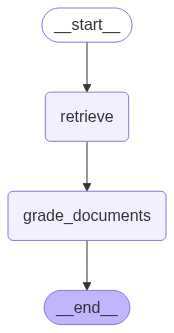

In [26]:
filter_graph

In [25]:
filter_graph.invoke(input={})

---RETRIEVE---


100%|██████████| 1/1 [00:00<00:00, 288.63it/s]


---CHECK DOCUMENT RELEVANCE TO QUESTION---


100%|██████████| 584/584 [05:19<00:00,  1.83it/s]

Number of relevant documents: 359


{'documents': [Document(metadata={'source': '../data/crawled_content/utsa_edu_3000.txt'}, page_content='LINK: https://utsa.edu/strategicplan/destinations/student-success.html\nTITLE: Model for Student Success | Strategic Plan - A Vision for UTSA | UTSA | University of Texas at San Antonio\nCONTENT:\nSearch icons\nUTSA Today\nmyUTSA\nSearch\n\nDestination One\n\n\nUTSA will be a Model for Student Success\n\nUTSA puts students first by cultivating an environment focused on their success.\nAs a next generation Hispanic-thriving, multicultural institution where students from all backgrounds can excel, UTSA serves as a prosperity engine graduating world-engaged civic leaders of tomorrow.\nKEY INTIATIVES THAT SUPPORT THIS DESTINATION\n\nOperationalized or Complete\n\n\nIn Progress\n\n\nKey Performance Indicators that Track Progress Toward Destination One\n\n- Total Student Enrollment\n- First-Year Retention Rate\n- 4-Year Graduation Rate\n- 6-Year Graduation Rate\n- Incoming First-Year Stude